In [1]:
# INR Reconstruction and Analysis Notebook
# This notebook loads trained INR model weights, reconstructs the original slices,
# compares reconstructed vs. original images, and computes performance metrics.

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys





# import your INR model definitions
from src.inr_models import SmallMLP_INR, TinySIREN

In [2]:
# Helper functions
def load_coords_vals(slice_dir, prefix):
    coords = np.load(os.path.join(slice_dir, f"{prefix}_coords.npy"))
    vals = np.load(os.path.join(slice_dir, f"{prefix}_vals.npy"))
    return coords, vals

def reconstruct_image(model, coords, grid_shape):
    device = next(model.parameters()).device
    coords_t = torch.from_numpy(coords).to(device)
    with torch.no_grad():
        preds = model(coords_t).cpu().numpy()
    return preds.reshape(grid_shape)

In [3]:
# Configuration
data_root = "data/Processed/BRATS_Subset"
results_root = "data/Thetas/Baseline_SMALL_INR/BRATS_Subset"
model_mapping = {
    "small_mlp": SmallMLP_INR,
    "tiny_siren": TinySIREN,
}
omega_0 = 30

In [4]:
# Reconstruction and plotting
def analyze_class(cls_name, model_type="small_mlp"):
    slice_folder = os.path.join(data_root, cls_name)
    theta_folder = os.path.join(results_root, cls_name)
    prefixes = sorted([f.replace("_theta.pt", "") for f in os.listdir(theta_folder) if f.endswith("_theta.pt")])
    losses = []
    for prefix in prefixes:
        coords, vals = load_coords_vals(slice_folder, prefix)
        N = vals.size
        side = int(np.sqrt(N))
        grid_shape = (side, side)
        model = model_mapping[model_type](omega_0=omega_0) if model_type == "tiny_siren" else model_mapping[model_type]()
        theta = torch.load(os.path.join(theta_folder, prefix + "_theta.pt"))
        offset = 0
        for p in model.parameters():
            numel = p.numel()
            p.data = theta[offset:offset+numel].view_as(p).to(p.device)
            offset += numel
        model.eval()
        recon = reconstruct_image(model, coords, grid_shape)
        orig = vals.reshape(grid_shape)
        mse = ((recon - orig) ** 2).mean()
        losses.append(mse)
        if prefix == prefixes[len(prefixes)//2]:
            fig, axs = plt.subplots(1, 2, figsize=(8, 4))
            axs[0].imshow(orig, cmap='gray'); axs[0].set_title('Original')
            axs[1].imshow(recon, cmap='gray'); axs[1].set_title(f'Reconstructed ({model_type})')
            plt.suptitle(f"Class: {cls_name}, Slice: {prefix}")
            plt.show()
    print(f"{model_type} average MSE for class {cls_name}: {np.mean(losses):.6f}")
    return losses

In [5]:
# Run analysis for each class and model type
results = {}
for cls in sorted(os.listdir(data_root)):
    if not os.path.isdir(os.path.join(data_root, cls)): continue
    for mtype in model_mapping.keys():
        print(f"Analyzing {cls} with {mtype}...")
        losses = analyze_class(cls, model_type=mtype)
        results[(cls, mtype)] = losses

Analyzing NoTumor with small_mlp...


C:\Users\Emin\AppData\Local\Temp\ipykernel_22020\3273773513.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta = torch.load(os.path.join(theta_folder, prefix + "_the

RuntimeError: shape '[256, 256]' is invalid for input of size 3553

In [6]:
# Summary table of average losses
import pandas as pd
summary = []
for (cls, mtype), losses in results.items():
    summary.append({"Class": cls, "Model": mtype, "Avg_MSE": np.mean(losses)})
df = pd.DataFrame(summary)
df

""


In [7]:
# Display as table
import ace_tools as tools; tools.display_dataframe_to_user(name="INR Reconstruction Summary", dataframe=df)

ModuleNotFoundError: No module named 'ace_tools'

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from src.train_inr import train_inr_model, train_tiny_siren_with_wt


d:\Emin\PythonProjects\lfd_project\.venv\lib\site-packages\kfac\base_preconditioner.py:15: UserWarning: NVIDIA Apex is not installed or was not installed with --cpp_ext. Falling back to PyTorch flatten and unflatten.
  from kfac.distributed import get_rank


In [9]:
coords = np.load(r"D:\Emin\PythonProjects\lfd_project\data\Processed\BRATS_Subset\NoTumor\BraTS2021_00061_slice_103_coords.npy")
vals = np.load(r"D:\Emin\PythonProjects\lfd_project\data\Processed\BRATS_Subset\NoTumor\BraTS2021_00061_slice_103_vals.npy")


In [22]:
theta,losses,pred = train_inr_model(coords, vals, save_path=r"D:\Emin\PythonProjects\lfd_project\trial\a.pt", use_kfac=True, model_type="tiny_siren",Epoch=1500, lr_=1e-4)


Using device: cuda
Using KFAC optimizer with preconditioner
Epoch 0, Loss = 0.157267
Epoch 33, Loss = 0.004247
Epoch 66, Loss = 0.002612
Epoch 99, Loss = 0.002088
Epoch 132, Loss = 0.001930
Epoch 165, Loss = 0.001982
Epoch 198, Loss = 0.001764
Epoch 231, Loss = 0.004910
Epoch 264, Loss = 0.001658
Epoch 297, Loss = 0.001330
Epoch 330, Loss = 0.001121
Epoch 363, Loss = 0.001612
Epoch 396, Loss = 0.000773
Epoch 429, Loss = 0.001298
Epoch 462, Loss = 0.000841
Epoch 495, Loss = 0.000540
Epoch 528, Loss = 0.001129
Epoch 561, Loss = 0.000456
Epoch 594, Loss = 0.000476
Epoch 627, Loss = 0.000385
Epoch 660, Loss = 0.000358
Epoch 693, Loss = 0.000432
Epoch 726, Loss = 0.000233
Epoch 759, Loss = 0.000632
Epoch 792, Loss = 0.000912
Epoch 825, Loss = 0.000291
Epoch 858, Loss = 0.000181
Epoch 891, Loss = 0.000790
Epoch 924, Loss = 0.000208
Epoch 957, Loss = 0.000157
Epoch 990, Loss = 0.000389
Epoch 1023, Loss = 0.000159
Epoch 1056, Loss = 0.000468
Epoch 1089, Loss = 0.000161
Epoch 1122, Loss = 0.000

In [8]:
import os
import numpy as np
from PIL import Image
import glob

def convert_flat_npy_to_jpeg(input_dir, output_dir, shape=(240, 240)):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if not filename.endswith('.npy') or "coords" in filename:
            continue  # .npy değilse veya ismi "coords" içeriyorsa atla

        npy_path = os.path.join(input_dir, filename)
        try:
            arr = np.load(npy_path)
            arr = arr.reshape(shape)

            # Normalize to [0, 255]
            arr_min, arr_max = arr.min(), arr.max()
            arr = 255 * (arr - arr_min) / (arr_max - arr_min + 1e-8)
            arr = arr.astype(np.uint8)

            # Save as JPEG
            img = Image.fromarray(arr)
            save_name = os.path.splitext(filename)[0] + ".jpg"
            img.save(os.path.join(output_dir, save_name), "JPEG")
            print(f"Saved: {save_name}")
        except Exception as e:
            print(f"Skipping {filename}: {e}")

# Örnek kullanım:
convert_flat_npy_to_jpeg(r"D:\Emin\PythonProjects\lfd_project\data\Processed\BRATS_Subset\NoTumor", r"D:\Emin\PythonProjects\lfd_project\data\Jpeg\BRATS2021_Subset\NoTumor")


Saved: BraTS2021_00000_slice_103_vals.jpg
Saved: BraTS2021_00002_slice_119_vals.jpg
Saved: BraTS2021_00006_slice_113_vals.jpg
Saved: BraTS2021_00008_slice_117_vals.jpg
Saved: BraTS2021_00009_slice_119_vals.jpg
Saved: BraTS2021_00014_slice_100_vals.jpg
Saved: BraTS2021_00016_slice_110_vals.jpg
Saved: BraTS2021_00017_slice_119_vals.jpg
Saved: BraTS2021_00019_slice_119_vals.jpg
Saved: BraTS2021_00020_slice_106_vals.jpg
Saved: BraTS2021_00021_slice_117_vals.jpg
Saved: BraTS2021_00024_slice_115_vals.jpg
Saved: BraTS2021_00025_slice_100_vals.jpg
Saved: BraTS2021_00026_slice_105_vals.jpg
Saved: BraTS2021_00028_slice_113_vals.jpg
Saved: BraTS2021_00032_slice_119_vals.jpg
Saved: BraTS2021_00033_slice_110_vals.jpg
Saved: BraTS2021_00036_slice_117_vals.jpg
Saved: BraTS2021_00043_slice_103_vals.jpg
Saved: BraTS2021_00044_slice_113_vals.jpg
Saved: BraTS2021_00045_slice_119_vals.jpg
Saved: BraTS2021_00046_slice_118_vals.jpg
Saved: BraTS2021_00048_slice_117_vals.jpg
Saved: BraTS2021_00051_slice_116_v

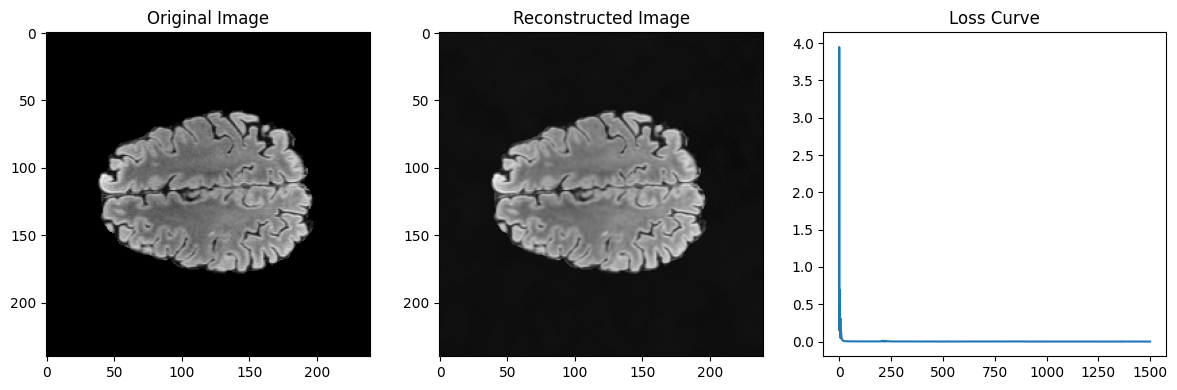

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(vals.reshape((240, 240)), cmap='gray')
plt.title("Original Image")
plt.subplot(1, 3, 2)
plt.imshow(pred, cmap='gray')
plt.title("Reconstructed Image")
plt.subplot(1, 3, 3)
plt.plot(losses)
plt.title("Loss Curve")
plt.tight_layout()
plt.show()


[0.08672759681940079, 0.06309647858142853, 0.05293775349855423, 0.05888846516609192, 0.0566381961107254, 0.05288803204894066, 0.05257154628634453, 0.053620439022779465, 0.053820088505744934, 0.053237929940223694, 0.0524451844394207, 0.05184434726834297, 0.05163329839706421, 0.051696643233299255, 0.05166839808225632, 0.05132758244872093, 0.050916995853185654, 0.05064387992024422, 0.050460875034332275, 0.050083477050065994, 0.04947366565465927, 0.04880663752555847, 0.04814387112855911, 0.047326184809207916, 0.046280890703201294, 0.045082371681928635, 0.043571457266807556, 0.04161452502012253, 0.03937701880931854, 0.03669383376836777, 0.03369743749499321, 0.0306490920484066, 0.028021804988384247, 0.02720913477241993, 0.025972774252295494, 0.02190677635371685, 0.022085433825850487, 0.022076327353715897, 0.018473057076334953, 0.019619770348072052, 0.017710261046886444, 0.016713280230760574, 0.016947081312537193, 0.01526688039302826, 0.01606711372733116, 0.014428085647523403, 0.0152074769139

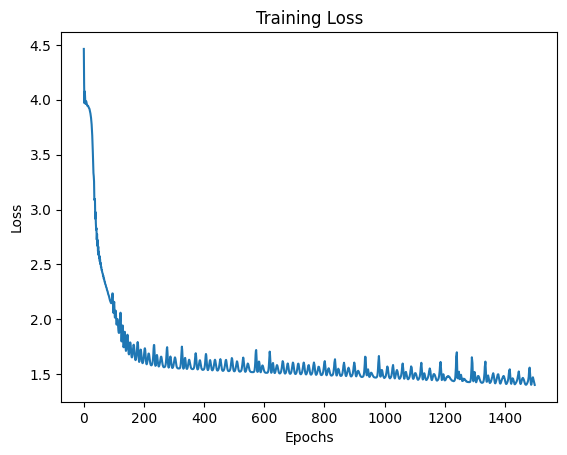

In [19]:
print(losses)
print(f"Final loss: {losses[-1]}")
#scale loses with 2
losses = [l * 1000 for l in losses]
plt.plot(np.log(losses))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()


In [5]:
from src.inr_models import SmallMLP_INR, TinySIREN
def reconstruct_and_compare(coords, vals,theta,model_type="small_mlp"):
    def reconstruct_image(model, coords, grid_shape):
        device = next(model.parameters()).device
        coords_t = torch.from_numpy(coords).to(device)
        with torch.no_grad():

            preds = model(coords_t).cpu().numpy()

        return preds.reshape(grid_shape)
    N = vals.size
    side = int(np.sqrt(N))
    grid_shape = (side, side)

    # Modeli tekrar yarat
    if model_type == "tiny_siren":
        model = TinySIREN(omega_0=30)
    else:
        model = SmallMLP_INR()
    model.eval()

    # theta'yı modele aktar
    offset = 0
    theta_t = theta.to(torch.float32)  # güvenli olmak için
    for p in model.parameters():
        numel = p.numel()
        p.data = theta_t[offset:offset + numel].view_as(p)
        offset += numel

    # Rekonstrüksiyon
    recon = reconstruct_image(model, coords, grid_shape)  # side = √N

    # Orijinal
    original = vals.reshape((side, side))

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original")

    plt.subplot(1, 2, 2)
    plt.imshow(recon, cmap='gray')
    plt.title("Reconstructed")

    plt.show()
reconstruct_and_compare(coords, vals,theta)

NameError: name 'coords' is not defined

C:\Users\Emin\AppData\Local\Temp\ipykernel_18220\3823388014.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta  = torch.load(theta_path)


🔍 NoTumor: BraTS2021_00002_slice_119 tiny_siren - 1/5


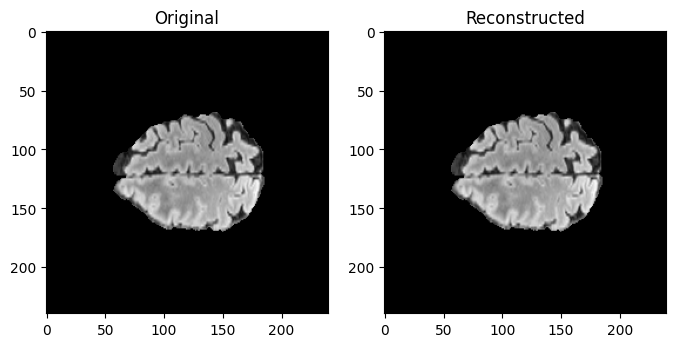

🔍 NoTumor: BraTS2021_00009_slice_119 tiny_siren - 2/5


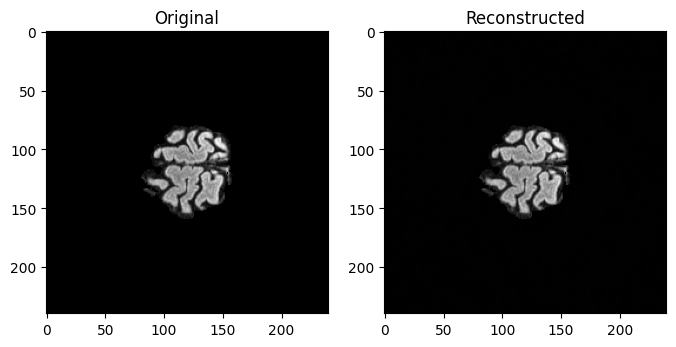

🔍 NoTumor: BraTS2021_00014_slice_100 tiny_siren - 3/5


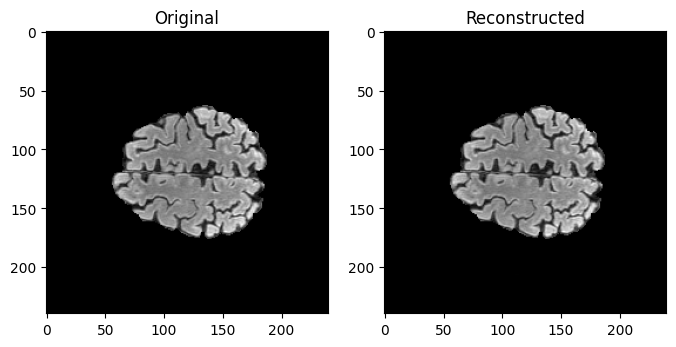

🔍 NoTumor: BraTS2021_00016_slice_110 tiny_siren - 4/5


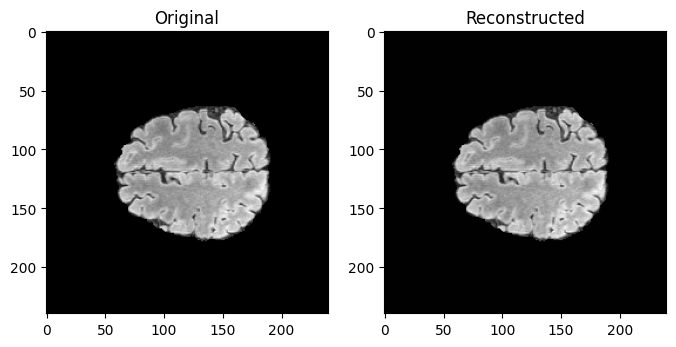

🔍 NoTumor: BraTS2021_00017_slice_119 tiny_siren - 5/5


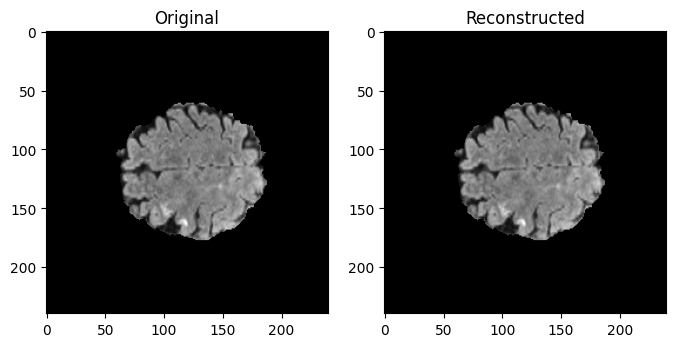

🔍 Tumor: BraTS2021_00002_slice_100 tiny_siren - 1/5


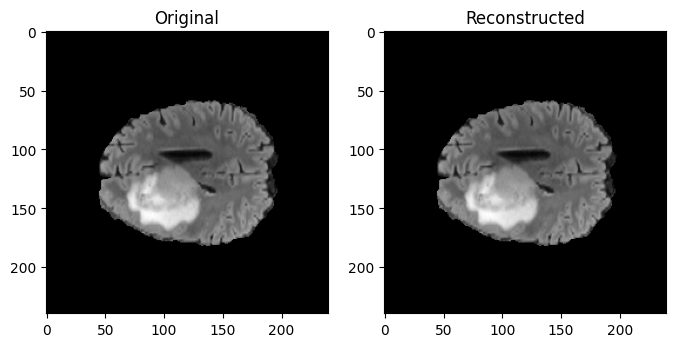

🔍 Tumor: BraTS2021_00003_slice_107 tiny_siren - 2/5


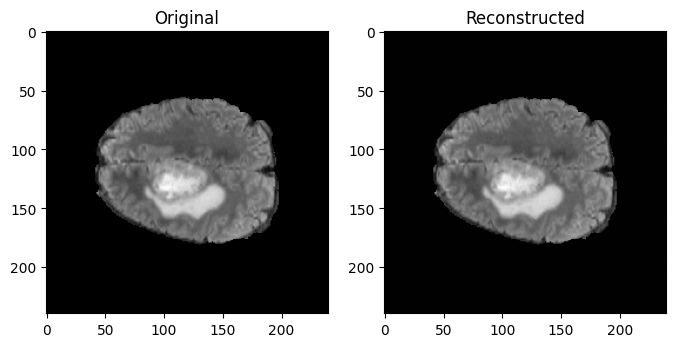

🔍 Tumor: BraTS2021_00005_slice_107 tiny_siren - 3/5


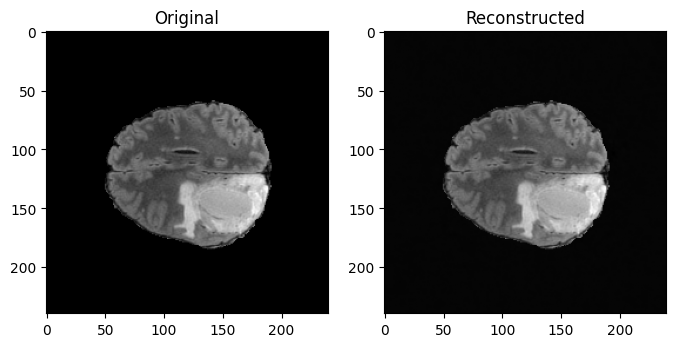

🔍 Tumor: BraTS2021_00006_slice_102 tiny_siren - 4/5


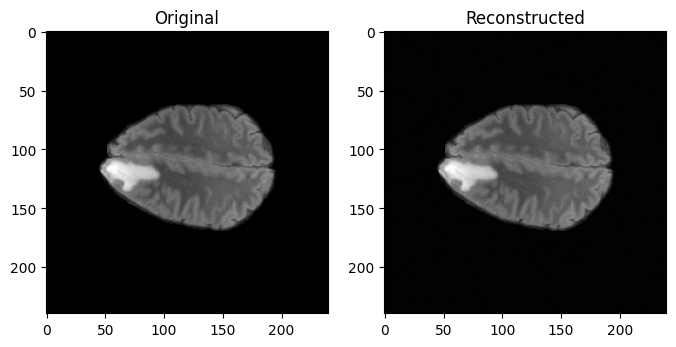

🔍 Tumor: BraTS2021_00011_slice_113 tiny_siren - 5/5


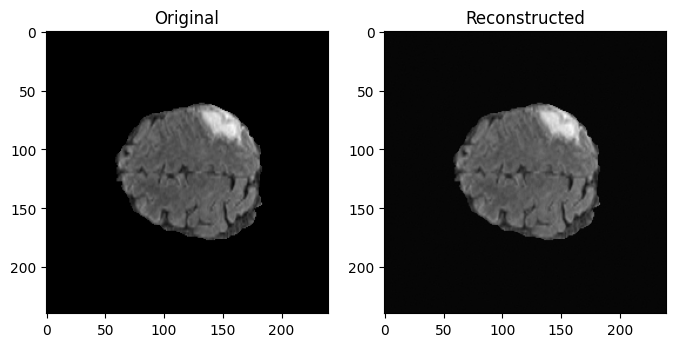

🔍 NoTumor: BraTS2021_00000_slice_103 small_mlp - 1/5


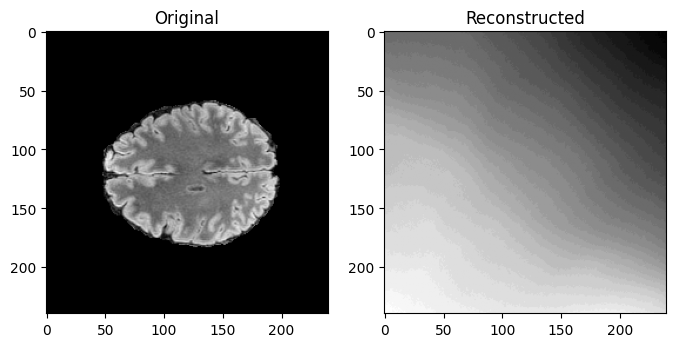

🔍 NoTumor: BraTS2021_00002_slice_119 small_mlp - 2/5


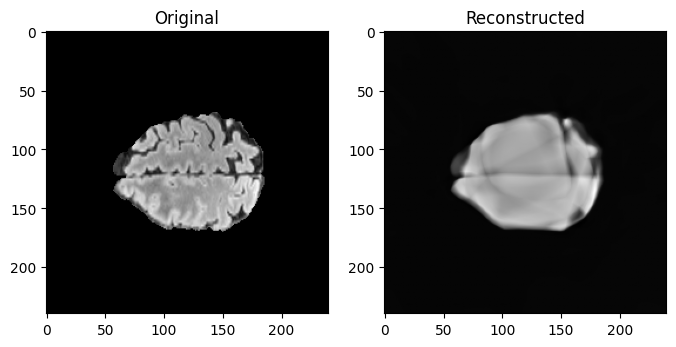

🔍 NoTumor: BraTS2021_00014_slice_100 small_mlp - 3/5


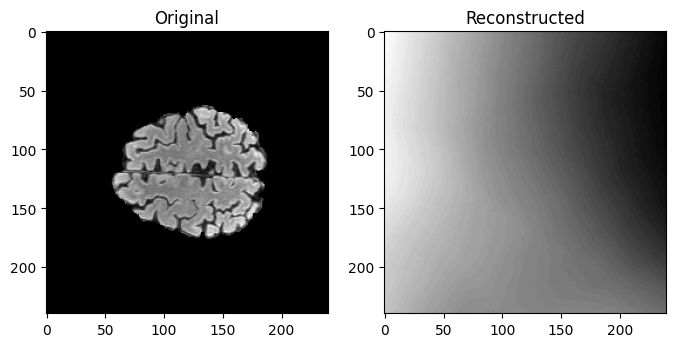

🔍 NoTumor: BraTS2021_00017_slice_119 small_mlp - 4/5


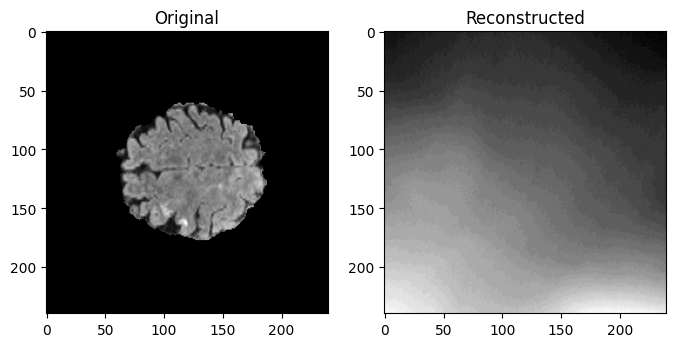

🔍 NoTumor: BraTS2021_00019_slice_119 small_mlp - 5/5


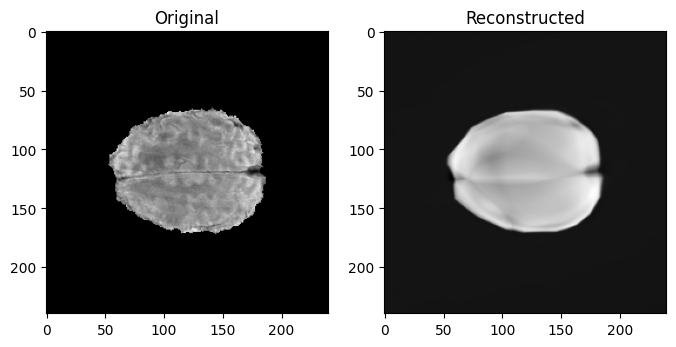

🔍 Tumor: BraTS2021_00003_slice_107 small_mlp - 1/5


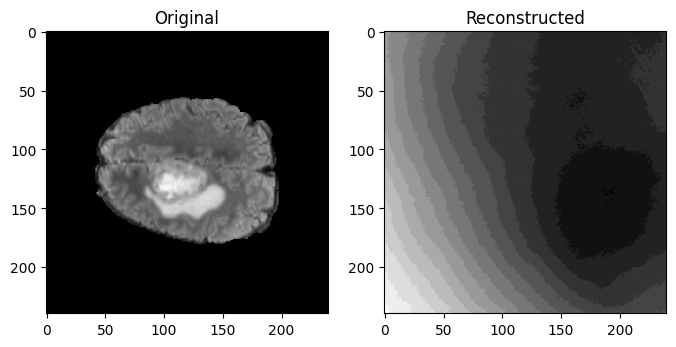

🔍 Tumor: BraTS2021_00005_slice_107 small_mlp - 2/5


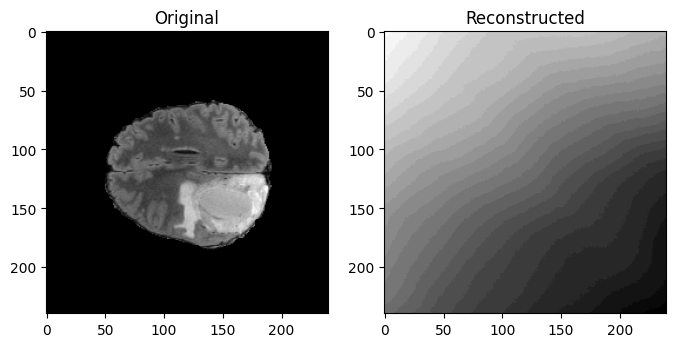

🔍 Tumor: BraTS2021_00006_slice_102 small_mlp - 3/5


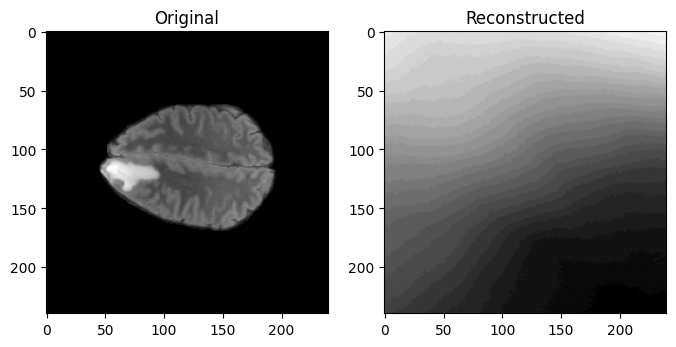

🔍 Tumor: BraTS2021_00009_slice_101 small_mlp - 4/5


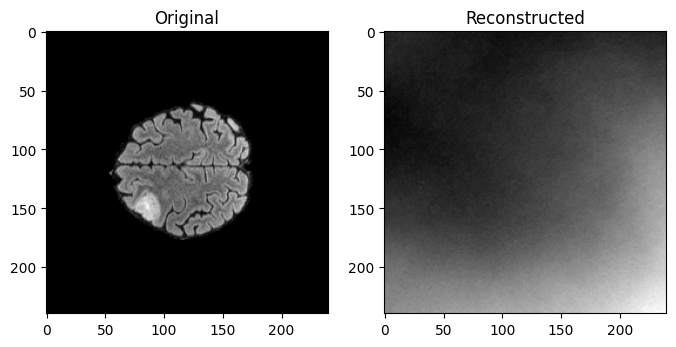

🔍 Tumor: BraTS2021_00012_slice_101 small_mlp - 5/5


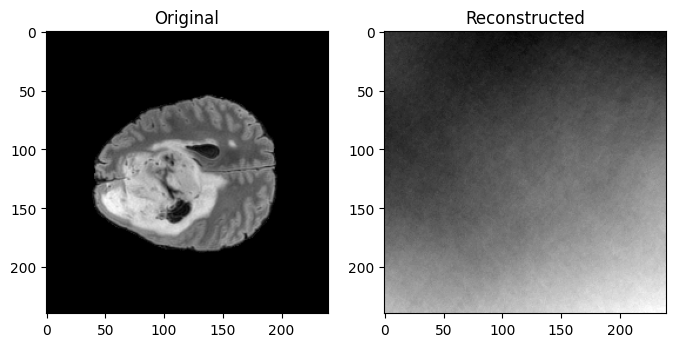

In [7]:
import os
import numpy as np
import torch
def visualize_some_samples(method_root, max_per_class=5,model_type="small_mlp"):
    for cls in ["NoTumor", "Tumor"]:
        cls_dir = os.path.join(method_root, cls)
        theta_files = sorted(f for f in os.listdir(cls_dir) if f.endswith("_theta.pt"))

        shown = 0
        for fname in theta_files:
            theta_path = os.path.join(cls_dir, fname)
            base = fname.replace("_theta.pt", "")
            coords_path = os.path.join(r"D:\Emin\PythonProjects\lfd_project\data\Processed\BRATS_Subset",cls+f"\{base}_coords.npy")
            vals_path   = os.path.join(r"D:\Emin\PythonProjects\lfd_project\data\Processed\BRATS_Subset",cls+f"\{base}_vals.npy")

            if not (os.path.exists(coords_path) and os.path.exists(vals_path)):
                print(f"⚠️ Missing coords/vals for {base}")
                print(f"  coords: {coords_path}")
                print(f"  vals: {vals_path}")
                continue

            theta  = torch.load(theta_path)


            print(f"🔍 {cls}: {base} {model_type} - {shown + 1}/{max_per_class}")
            reconstruct_and_compare(np.load(coords_path), np.load(vals_path), theta, model_type=model_type)

            shown += 1
            if shown >= max_per_class:
                break




visualize_some_samples("output/thetas/Siren_wt", max_per_class=5, model_type="tiny_siren")
visualize_some_samples("output/thetas/Small_Mlp_Base_Line", max_per_class=5, model_type="small_mlp")